In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, cv2
import random
import seaborn as sns
import numba

In [2]:
def Particle(x,y,z,num_0,step):
    x0, y0, z0 = x[:,num_0], y[:,num_0], z[:,num_0]
    Gt = np.array([])
    t = np.array([])
    t_step = 100
    count = x.shape[0]
    
    for i in range(L,count-step):
        x1, y1, z1 = x0[i: i + step], y0[i: i + step], z0[i: i + step]
        x_m, y_m, z_m = np.mean(x1), np.mean(y1), np.mean(z1)
        Gt = np.append(Gt,3. / np.mean(((x1-x_m)**2 + (y1-y_m)**2 + (z1-z_m)**2)))
  

    return np.mean(Gt)

In [3]:
def Core(x,y,z,step):
    count = x.shape[0]
    L = int(count*2/3.)
    t_step = 100
    Gt_core = np.array([])
    t = np.array([])
    r = np.mean(np.sqrt(x[L:,:]**2+y[L:,:]**2+z[L:,:]**2), axis=0)
    n = np.argsort(r)
    R = x.shape[1]**(1./3)
    pl = n[(r<=2*R/3)]
    count = x.shape[0]

    for i in range(L,count-step):
        x1, y1, z1 = x[i: i + step,pl], y[i: i + step,pl], z[i: i + step,pl]
        x_m, y_m, z_m = np.mean(x1,axis=0), np.mean(y1,axis=0), np.mean(z1,axis=0)
        Gt_core = np.append(Gt_core,3. / np.mean(np.mean(((x1-x_m)**2 + (y1-y_m)**2 + (z1-z_m)**2), axis=1)))

#     return Gt_core
    return np.mean(Gt_core)

In [4]:
def All(x,y,z,step):
    Gt_all = np.array([])
    count = x.shape[0]
    t_step = 100

    for i in range(L,count-step):
        x1, y1, z1 = x[i: i + step,:], y[i: i + step,:], z[i: i + step,:]
        x_m, y_m, z_m = np.mean(x1,axis=0), np.mean(y1,axis=0), np.mean(z1,axis=0)
        Gt_all = np.append(Gt_all,3. / np.mean(np.mean(((x1-x_m)**2 + (y1-y_m)**2 + (z1-z_m)**2), axis=1)))
        

    return np.mean(Gt_all)

In [5]:
@numba.njit
def force_sim(x, y, z, N): #вычисление матрицы сил f/m по 1-ой координате

    f_x, f_y, f_z = np.zeros(N), np.zeros(N), np.zeros(N)
    for i in range(N):
        r0 = np.sqrt(x[i]**2 + y[i]**2 + z[i]**2)
        if ((r0 > N**(1/3.))):
            f_x[i] = -x[i] * N / (r0 ** 3)
            f_y[i] = -y[i] * N / (r0 ** 3)
            f_z[i] = -z[i] * N / (r0 ** 3)
        else:
            f_x[i] = -x[i]
            f_y[i] = -y[i]
            f_z[i] = -z[i]

    for i in range(0, N):
        for j in range(0, N):
            if (j != i):
                dx = x[i] - x[j]
                dy = y[i] - y[j]
                dz = z[i] - z[j]

                xi_ij = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

                f_x[i] = f_x[i] + dx / (xi_ij ** 3)
                f_y[i] = f_y[i] + dy / (xi_ij ** 3)
                f_z[i] = f_z[i] + dz / (xi_ij ** 3)

    return f_x, f_y, f_z

In [6]:
def G_force(G,num_0):
    r = np.mean(np.sqrt(x[L:,:]**2+y[L:,:]**2+z[L:,:]**2), axis=0)
    n = np.argsort(r)
    
    R = x.shape[1]**(1./3)

    pl = n[(r<=2*R/3)]
    force = np.array([])
    force_central = np.array([])
    force_core = np.array([])
    V = 3/np.mean(np.mean(vx[L:,:]**2 + vy[L:,:]**2 + vz[L:,:]**2, axis=1))
    V_core = 3/np.mean(np.mean(vx[L:,pl]**2 + vy[L:,pl]**2 + vz[L:,pl]**2, axis=1))
    V_c = 3/np.mean(vx[L:,num_0]**2 + vy[L:,num_0]**2 + vz[L:,num_0]**2)
    print(pl.shape)
    
    for i in range(L, count):
        fx, fy, fz = force_sim(x[i,:],y[i,:],z[i,:],Np) 
        force = np.append(force, np.mean(fx**2 + fy**2 + fz**2))
        force_central = np.append(force_central, (fx[num_0]**2 + fy[num_0]**2 + fz[num_0]**2))
        force_core = np.append(force_core, np.mean(fx[pl]**2 + fy[pl]**2 + fz[pl]**2))
    f = np.mean(force)/3. * V**2
    f_c = np.mean(force_central)/3. * V_c**2
    f_core = np.mean(force_core)/3. * V_c**2
    
    return f_c, f_core, f
    
    
#     return G, np.mean(f_c),np.mean(f_core), np.mean(f)

In [7]:
def G_V(G, num_0):
    
    # all particles
    V = 3/np.mean(vx[L:,:]**2 + vy[L:,:]**2 + vz[L:,:]**2)
    V1 = V

    # central particle

    V = 3/np.mean(vx[L:,num_0]**2 + vy[L:,num_0]**2 + vz[L:,num_0]**2)
    V2 =V

    
    r = np.mean(np.sqrt(x[L:,:]**2+y[L:,:]**2+z[L:,:]**2), axis=0)
    n = np.argsort(r)
    R = x.shape[1]**(1./3)
    pl = n[(r<=2*R/3)]

    vcx, vcy, vcz = vx[L:,pl], vy[L:,pl], vz[L:,pl]
    V = 3/np.mean(vcx**2 + vcy**2 + vcz**2)
    
    return V2, V, V1

In [8]:
def G_r(dr):
    st = 2000
    gr = 3/np.mean((x-np.mean(x[st:,:],axis=0))**2 + (y-np.mean(y[st:,:],axis=0))**2 + (z-np.mean(z[st:,:],axis=0))**2, axis=1)
    tl = np.arange(gr.shape[0])
    count = x.shape[0]
    
    rall = 3./np.mean(3./gr[int(gr.shape[0]/2):])

    x0, y0, z0 = np.mean(x,axis=0), np.mean(y,axis=0), np.mean(z,axis=0)
    num_0 = np.argmin(x0**2 + y0**2 + z0**2)
    x1,y1,z1 = x[:,num_0], y[:,num_0], z[:,num_0]
    count = x.shape[0]
    gr_c = 3/((x[:,num_0]-np.mean(x[st:,num_0],axis=0))**2 + (y[:,num_0]-np.mean(y[st:,num_0],axis=0))**2 + (z[:,num_0]-np.mean(z[st:,num_0],axis=0))**2)
    rc = 3./np.mean(3./gr_c[int(gr_c.shape[0]/2):])
    r = np.mean(np.sqrt(x[L:,:]**2+y[L:,:]**2+z[L:,:]**2), axis=0)
    n = np.argsort(r)
    R = x.shape[1]**(1./3)
    pl = n[(r<=2*R/3)]
    gr_core= 3/np.mean((x[:,pl]-np.mean(x[st:,pl],axis=0))**2 + (y[:,pl]-np.mean(y[st:,pl],axis=0))**2 + (z[:,pl]-np.mean(z[st:,pl],axis=0))**2, axis=1)
    rcor = 3./np.mean(3./gr_core[int(gr_core.shape[0]/2):])

    
    return rc, rcor, rall

In [9]:
def G_dirty(a):
    h = 0.01
    
    r = np.mean(np.sqrt(x[L:,:]**2+y[L:,:]**2+z[L:,:]**2), axis=0)
    n = np.argsort(r)
    
    R = x.shape[1]**(1./3)

    num = n[(r<=2*R/3)]
    gamma = 0.09

    a2 = np.zeros(3)
    
    f2 = (fy[L:,:]**2+fx[L:,:]**2+fz[L:,:]**2)
    a2[2] = 3./np.mean(f2) * (1 - gamma * (gamma - 2./h))
    a2[0] = 3./np.mean(f2[:,num_0]) * (1 - gamma * (gamma - 2./h))
    a2[1] = 3./np.mean(f2[:,num]) * (1 - gamma * (gamma - 2./h))
    return a2

In [53]:
L = 2000
count = 3000
Np = 1075
G_date = np.arange(10,210,10)
G_date = np.append(G_date, [250, 500])
data = np.array([])
time = np.arange(L,count)
# time_all = np.arange(0,count)
Gt_all_coord, Gt_all_V, Gt_all_force, Gt_all_dirty, Gt_all_l5, Gt_all_l10 = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
Gt_core_coord, Gt_core_V, Gt_core_force, Gt_core_dirty, Gt_core_l5, Gt_core_l10 = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
Gt_part_coord, Gt_part_V, Gt_part_force, Gt_part_dirty, Gt_part_l5, Gt_part_l10 = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for dr in G_date:
    print(dr)

    dir_name = '/Users/elizavetashpilko/Desktop/Work/test/HCP/N=853/0/'+str(dr)+'/'

    x = np.loadtxt(dir_name+"x_{}.txt".format(dr), dtype='float64')
    y = np.loadtxt(dir_name+"y_{}.txt".format(dr), dtype='float64')
    z = np.loadtxt(dir_name+"z_{}.txt".format(dr), dtype='float64')
    
    vx = np.loadtxt(dir_name+"v_x_{}.txt".format(dr), dtype='float64')
    vy = np.loadtxt(dir_name+"v_y_{}.txt".format(dr), dtype='float64')
    vz = np.loadtxt(dir_name+"v_z_{}.txt".format(dr), dtype='float64')
    
    fx = np.loadtxt(dir_name+"force_x_{}.txt".format(dr), dtype='float64')
    fy = np.loadtxt(dir_name+"force_y_{}.txt".format(dr), dtype='float64')
    fz = np.loadtxt(dir_name+"force_z_{}.txt".format(dr), dtype='float64')
    
    num_0 = np.argmin(np.mean(x[L:,:]**2 + y[L:,:]**2 + z[L:,:]**2, axis=0))
    
#     GT_part, GT_core, GT_all = G_r(dr)
#     Gt_all_coord = np.append(Gt_all_coord, GT_all)
#     Gt_core_coord = np.append(Gt_core_coord, GT_core)
#     Gt_part_coord = np.append(Gt_part_coord, GT_part)
    
#     GT_part, GT_core, GT_all = G_V(dr, num_0)
#     Gt_all_V = np.append(Gt_all_V, GT_all)
#     Gt_core_V = np.append(Gt_core_V, GT_core)
#     Gt_part_V = np.append(Gt_part_V, GT_part)
    
#     GT_part, GT_core, GT_all = G_force(dr, num_0)
#     Gt_all_force = np.append(Gt_all_force, GT_all)
#     Gt_core_force = np.append(Gt_core_force, GT_core)
#     Gt_part_force = np.append(Gt_part_force, GT_part)
    
#     GT_part, GT_core, GT_all = G_dirty(dr)
#     Gt_all_dirty = np.append(Gt_all_dirty, GT_all)
#     Gt_core_dirty = np.append(Gt_core_dirty, GT_core)
#     Gt_part_dirty = np.append(Gt_part_dirty, GT_part)
    
    GT_part, GT_core, GT_all = Particle(x,y,z,num_0,step=5), Core(x,y,z,step=5), All(x,y,z,step=5)
    Gt_all_l5 = np.append(Gt_all_l5, GT_all)
    Gt_core_l5 = np.append(Gt_core_l5, GT_core)
    Gt_part_l5 = np.append(Gt_part_l5, GT_part)
    
    GT_part, GT_core, GT_all = Particle(x,y,z,num_0,step=10), Core(x,y,z,step=10), All(x,y,z,step=10)
    Gt_all_l10 = np.append(Gt_all_l10, GT_all)
    Gt_core_l10 = np.append(Gt_core_l10, GT_core)
    Gt_part_l10 = np.append(Gt_part_l10, GT_part)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
250
500


In [54]:
header = ["Г", "Central particle", "Core", "All"]
# pd.DataFrame(np.transpose(np.array([G_date, Gt_part_coord, Gt_core_coord, Gt_all_coord]))).to_csv('Coordinate N={}.csv'.format(x.shape[1]),index=False, header=header)
# pd.DataFrame(np.transpose(np.array([G_date, Gt_part_V, Gt_core_V, Gt_all_V]))).to_csv('Velocity N={}.csv'.format(x.shape[1]),index=False, header=header)
# pd.DataFrame(np.transpose(np.array([G_date, Gt_part_force, Gt_core_force, Gt_all_force]))).to_csv('Force N={}.csv'.format(x.shape[1]),index=False, header=header)
# pd.DataFrame(np.transpose(np.array([G_date, Gt_part_dirty, Gt_core_dirty, Gt_all_dirty]))).to_csv('Dirty force N={}.csv'.format(x.shape[1]),index=False, header=header)
pd.DataFrame(np.transpose(np.array([G_date, Gt_part_l5, Gt_core_l5, Gt_all_l5]))).to_csv('Gamma_l N={}, l=5.csv'.format(x.shape[1]),index=False, header=header)
pd.DataFrame(np.transpose(np.array([G_date, Gt_part_l10, Gt_core_l10, Gt_all_l10]))).to_csv('Gamma_l N={}, l=10.csv'.format(x.shape[1]),index=False, header=header)


In [49]:
header = ["Г", "Central particle", "Core", "All"]
pd.DataFrame(np.transpose(np.array([G_date, Gt_part, Gt_core, Gt_all]))).to_csv('Coordinate N={}.csv'.format(x.shape[1]),index=False, header=header)

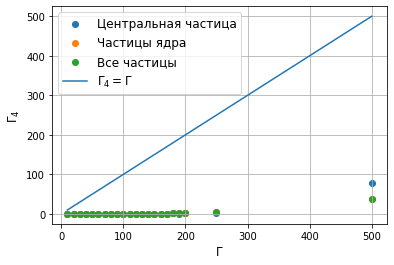

In [50]:
plt.scatter(G_date, Gt_part, label="Центральная частица")
plt.scatter(G_date, Gt_core, label="Частицы ядра")
plt.scatter(G_date, Gt_all, label="Все частицы")
plt.plot(G_date, G_date, label='$\\Gamma_4 = \\Gamma$')
plt.ylabel("$\\Gamma_4$",fontsize=12)
plt.xlabel("$\\Gamma$",fontsize=12)
plt.grid()
# plt.ylim(0,550)
plt.legend(fontsize=12)
# plt.savefig('G dirty force N={}.png'.format(Np), bbox_inches='tight')

In [154]:
N=335
data = np.reshape(data, (G_date.shape[0],4))
# pd.DataFrame(data).to_csv('Force_{}.csv'.format(N), index=False, header=['Gamma','Central','Core','All'])
data

array([[2.00000000e+01, 9.41984861e-02, 1.36075637e-01, 9.77851965e-02],
       [3.00000000e+01, 1.33020625e-01, 1.43954582e-01, 9.05017312e-02],
       [4.00000000e+01, 1.01482560e-01, 1.59846977e-01, 1.04658621e-01],
       [5.00000000e+01, 1.29889748e-01, 1.77767570e-01, 1.42960175e-01],
       [6.00000000e+01, 2.11618444e-01, 2.04690028e-01, 1.57215956e-01],
       [7.00000000e+01, 1.52248199e-01, 2.26609734e-01, 2.11246994e-01],
       [8.00000000e+01, 3.27914288e-01, 2.58920012e-01, 2.52131430e-01],
       [9.00000000e+01, 2.73072013e-01, 2.61708938e-01, 2.70898223e-01],
       [1.00000000e+02, 4.87433502e-01, 3.55585295e-01, 3.46467109e-01],
       [1.10000000e+02, 4.22035529e-01, 4.28805443e-01, 4.37599713e-01],
       [1.20000000e+02, 9.33364348e-01, 4.31287283e-01, 4.81073116e-01],
       [1.30000000e+02, 2.53871249e+01, 4.64643359e-01, 5.12490823e-01],
       [1.40000000e+02, 2.72173834e+01, 7.11524420e-01, 7.26152593e-01],
       [1.50000000e+02, 3.81041001e+01, 7.59799368e

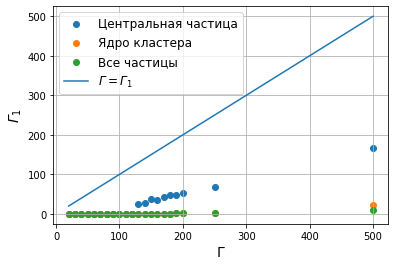

In [156]:
plt.scatter(data[:,0], np.abs(data[:,1]),label='Центральная частица')
plt.scatter(data[:,0], data[:,2],label='Ядро кластера')
plt.scatter(data[:,0], data[:,3],label='Все частицы')
plt.plot(data[:,0], data[:,0],label='$Г=Г_1$')
plt.xlabel('Г',fontsize=14)
plt.ylabel('$Г_1$',fontsize=14)
# plt.ylim(0,510)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('Coordinate_{}.png'.format(N))

In [105]:
G_date = np.arange(10,210,10)
G_date = np.append(G_date, np.array([250,500]))

for a in G_date:
    x = np.array([])
    y = np.array([])
    z = np.array([])
    vy = np.array([])
    vz = np.array([])

    G = str(a)
    count = 3000
    dir_name = '/Users/elizavetashpilko/Desktop/Work/test/HCP/N=1075/0/'+G+'/'
#     plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
    
    x = np.loadtxt(dir_name+"x_{}.txt".format(a), dtype='float64')
    y = np.loadtxt(dir_name+"y_{}.txt".format(a), dtype='float64')
    z = np.loadtxt(dir_name+"z_{}.txt".format(a), dtype='float64')

    vx = np.loadtxt(dir_name+"v_x_{}.txt".format(a), dtype='float64')
    vy = np.loadtxt(dir_name+"v_y_{}.txt".format(a), dtype='float64')
    vz = np.loadtxt(dir_name+"v_z_{}.txt".format(a), dtype='float64')

    fx = np.loadtxt(dir_name+"force_x_{}.txt".format(a), dtype='float64')
    fy = np.loadtxt(dir_name+"force_y_{}.txt".format(a), dtype='float64')
    fz = np.loadtxt(dir_name+"force_z_{}.txt".format(a), dtype='float64')

    h = 0.01
    num_0 = np.argmin(np.mean(x**2+y**2+z**2, axis=0))
    r = np.mean(np.sqrt(x**2+y**2+z**2), axis=0)
    n = np.argsort(r)
    
    R = x.shape[1]**(1./3)

    num = n[(r<=2*R/3)]
    gamma = 0.09

    a2 = np.zeros(4)
    gv = 3./np.mean(vx**2 + vy**2 + vz**2,axis=1)
    gv = 1./np.mean(1./gv[2000:])
    w0 = np.mean(vx**2 + vy**2 + vz**2,axis=1) / np.mean(x**2 + y**2 + z**2,axis=1)
    w0 = np.mean(w0[2000:])
    a2[0] = a
    a2[1] = gv

    f2 = fy[:,num_0]**2+fx[:,num_0]**2+fz[:,num_0]**2 - 6 * gamma/ (h * 3./(vy[:,num_0]**2+vx[:,num_0]**2+vz[:,num_0]**2)) + gamma * (vy[:,num_0]**2+vx[:,num_0]**2+vz[:,num_0]**2)
    force = np.mean(f2[2000:])
    print(np.mean(fy[2000:,num_0]**2+fx[2000:,num_0]**2+fz[2000:,num_0]**2 - 6 * gamma/ (h * gv) + gamma * (vy[2000:,num_0]**2+vx[2000:,num_0]**2+vz[2000:,num_0]**2)))
    a2[2] = 3./force

    f2 = np.mean(fy[:,num]**2+fx[:,num]**2+fz[:,num]**2 - 6 * gamma/ (h * gv) + gamma * (vy[:,num]**2+vx[:,num]**2+vz[:,num]**2),axis=1)
    force = np.mean(f2[2000:])
    a2[3] = 3./force

#     file = open('/Users/elizavetashpilko/Work/test/HCP/N=1075/Dirty_force_core.txt', 'a')
#     np.savetxt(file, a2, newline=" ", fmt='%f')
#     file.write("\n")
    print(a2)
    

0.48906170342306904
[10.         10.00287879  4.29937869 10.1376148 ]
0.025202056480271268
[20.         19.97711782 31.91512547 17.67050045]
0.08603118890016484
[30.         30.02564319 22.73732115 28.43013713]
0.06414027746041688
[40.         40.00809358 37.05803006 36.14124752]
0.07032538231416381
[50.         49.88952911 35.70822394 47.41463094]
0.017572582056199635
[ 60.          59.95393779 252.29722359  55.59918087]
0.03971520051475055
[ 70.          70.11623181 160.1999954   62.59909863]
0.05712355470348168
[80.         79.81915344 30.8350767  74.28503817]
0.03272529222063021
[ 90.          89.65009734 334.23305654  87.71675703]
0.027391448621466082
[100.         100.08518817  95.34991439  89.8091915 ]


KeyboardInterrupt: 

In [17]:
a = 500
    h = 0.01
    num_0 = np.argmin(np.mean(x**2+y**2+z**2, axis=0))
    print(np.amin(np.sqrt(x**2+y**2+z**2)))
    r = np.mean(np.sqrt(x**2+y**2+z**2), axis=0)
    num = np.argsort(r)
    r = np.sort(r)

    num = num[(r<=3)]
    gamma = 0.09

    a2 = np.zeros(4)
    gv = 3./np.mean(vx**2 + vy**2 + vz**2,axis=1)

    gv = 1./np.mean(1./gv[1500:])
    w0 = np.mean(vx**2 + vy**2 + vz**2,axis=1) / np.mean(x**2 + y**2 + z**2,axis=1)
    w0 = np.mean(w0[1500:])
    a2[0] = a
    a2[1] = gv

    f2 = fy[:,num_0]**2+fx[:,num_0]**2+fz[:,num_0]**2 - 6 * gamma/ (h * a) + gamma * (vy[:,num_0]**2+vx[:,num_0]**2+vz[:,num_0]**2)
    force = np.mean(f2[0:])
    a2[2] = 3./force

    f2 = np.mean(fy[:,num]**2+fx[:,num]**2+fz[:,num]**2 - 6 * gamma/ (h * gv) + gamma * (vy[:,num]**2+vx[:,num]**2+vz[:,num]**2),axis=1)
    force = np.mean(f2[1500:])
    a2[3] = 3./force

#     file = open('/Users/elizavetashpilko/Work/test/HCP/N=1075/Dirty_force_core.txt', 'a')
#     np.savetxt(file, a2, newline=" ", fmt='%f')
#     file.write("\n")
    print(a2)
    

IndentationError: unexpected indent (<ipython-input-17-60f0d93108c4>, line 2)

0.07916004418104149


NameError: name 'a2' is not defined

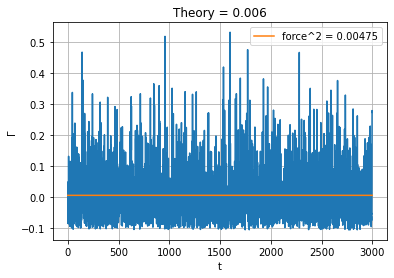

In [17]:
f2 = fy[:,num_0]**2+fx[:,num_0]**2+fz[:,num_0]**2 - 6 * gamma/ (h * gv) + gamma * (vy[:,num_0]**2+vx[:,num_0]**2+vz[:,num_0]**2)
force = np.mean(f2[1500:])
plt.plot(np.arange(count), f2)
plt.plot(np.arange(count), force*np.ones(count),label="force^2 = {}".format(round(force,5)))
plt.legend()
plt.title("Theory = {}".format(round(3./a,5)))
plt.grid()
plt.xlabel('t')
plt.ylabel("Г")
plt.savefig('Force_GV.png')
print(np.mean(f2[1500:]/10.)/(3./a))
a2[3] = np.round(force,5)